# Introduction

**Before conducting our analysis and implementation, these are some of the articles/research papers that we made reference from:**

H. Ismail, S. Harous, and Boumediene Belkhouche, “A Comparative Analysis of Machine Learning Classifiers for Twitter Sentiment Analysis,” ResearchGate, Apr. 03, 2016. https://www.researchgate.net/publication/300169929_A_Comparative_Analysis_of_Machine_Learning_Classifiers_for_Twitter_Sentiment_Analysis (accessed Nov. 05, 2023).

- One possible limitation from the “A Comparative Analysis of Machine Learning Classifiers for Twitter Sentiment Analysis" is the small training sample which consists of 177 negative and 182 positive manually annotated tweets only. Due to the insufficiency of training data, the prediction accuracy of classifiers with the Word2Vec embedding method is low.

- This significant increase in the size of our training data allows our model to better learn and generalize from a more extensive range of examples. The larger dataset provides a more representative sample of Twitter sentiment, improving the overall accuracy of our sentiment analysis model.

J. Brownlee, “Hyperparameter Optimization With Random Search and Grid Search - MachineLearningMastery.com,” MachineLearningMastery.com, Sep. 13, 2020. https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/ (accessed Nov. 05, 2023).

Y. Wang, J. Guo, C. Yuan, and B. Li, “Sentiment Analysis of Twitter Data,” Applied sciences, vol. 12, no. 22, pp. 11775–11775, Nov. 2022, doi: https://doi.org/10.3390/app122211775. (accessed Nov. 05, 2023)
- One limitation stated was the lack of consideration that the prediction accuracy of models is highly dependent on the classifiers that were taught by the target domain

- We used a broader n-gram range of (1,3) captures more contextual information from the text. We have chosen to include trigrams, which go beyond what some referenced reports have considered. This decision is made to enhance our model's ability to address the challenge of domain dependency. This approach is particularly valuable since our analysis encompasses a wide range of tweets and is not context-specific.


# Importing Relevant Libraries

In [ ]:
# Import necessary libraries and modules
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Import libraries for natural language processing
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Import Natural Language Toolkit (nltk) and download stopwords data
import nltk
import string
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Define a list of stopwords for text processing
stopwords = nltk.corpus.stopwords.words("english")

# Import a stemmer from nltk for text preprocessing
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Exploratory Data Analysis

#### Importing Twitter Dataset from Google Drive Link



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/sentiment_analysis/Dataset/dataset.csv", header=None)

In [ ]:
# Renaming columns names to make them more readable
data.rename({0:'label',1:'tweet'}, axis = 1, inplace = True)

In [ ]:
data.head()

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


#### Visualising the label distribution of the dataset

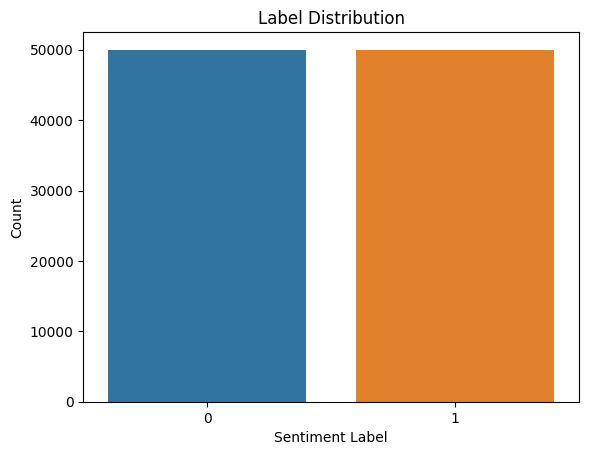

In [ ]:
label_counts = data['label'].value_counts()

# Create a bar chart using Seaborn
sns.barplot(x=label_counts.index, y=label_counts.values)

# Add labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Label Distribution')

# Show the plot
plt.show()

#### Visualising the distribution of length of tweets

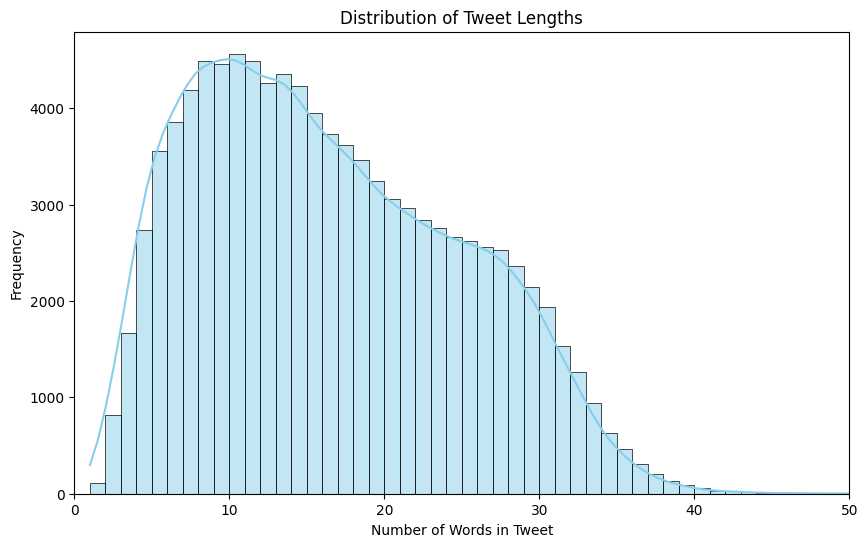

In [ ]:
# Tokenize the tweets to count the number of words
data['initial_tweet_length'] = data['tweet'].apply(lambda tweet: len(word_tokenize(tweet)))

# Create a histogram of tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='initial_tweet_length', bins=range(1, 51), kde=True, color='skyblue')

# Customize the x-axis limits
plt.xlim(0, 50)

# Customize the plot
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths")

# Show the plot
plt.show()

#### Visualising number of different characteristic of tweets with respect to the total number of tweets

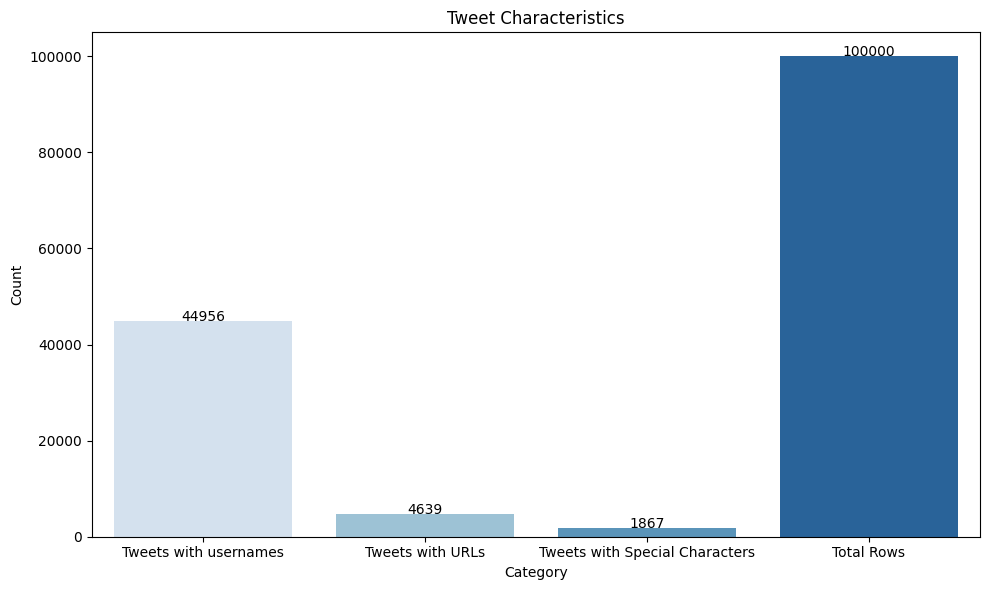

In [ ]:
tweets_with_usernames = sum(data['tweet'].str.contains(r"@[\w]+", regex=True))
tweets_with_urls = sum(data['tweet'].str.contains(r"http\S+|www\S+|https\S+", regex=True))
tweets_with_special_char = sum(data['tweet'].str.contains(r"#", regex=True))

# Calculate the total number of rows
total_rows = len(data)

# Create a DataFrame to store the data
data_to_plot = pd.DataFrame({'Category': ['Tweets with usernames', 'Tweets with URLs', 'Tweets with Special Characters', 'Total Rows'],
                             'Count': [tweets_with_usernames, tweets_with_urls, tweets_with_special_char, total_rows]})

# Create a Seaborn bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
ax = sns.barplot(x='Category', y='Count', data=data_to_plot, palette="Blues")

# Add labels and title
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Tweet Characteristics")

# Add count above each bar graph
for bar, count in zip(ax.patches, data_to_plot['Count']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, count, ha='center')

# Show the plot
plt.tight_layout()
plt.show()

# Data Preprocessing

#### Removing Usernames

In [ ]:
def remove_usernames(tweet):
    # Define a regex pattern to match usernames
    username_pattern = r'@[\w]+'

    # Use the sub() function to replace all matched usernames with an empty string
    cleaned_tweet = re.sub(username_pattern, '', tweet)

    return cleaned_tweet

In [ ]:
data['new_tweet'] = data['tweet'].apply(remove_usernames)
data.head()

,label,tweet,initial_tweet_length,new_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",27,"http://twitpic.com/2y1zl - Awww, that's a bum..."
1,0,is upset that he can't update his Facebook by ...,25,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,21,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire,10,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",30,"no, it's not behaving at all. i'm mad. why am..."


#### Removing Links

In [ ]:
def remove_urls(text):
    # Use a regular expression to remove URLs
    return re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

In [ ]:
data['new_tweet'] = data['new_tweet'].apply(remove_urls)
data.head()

,label,tweet,initial_tweet_length,new_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",27,- A that's a bummer. You shoulda got David ...
1,0,is upset that he can't update his Facebook by ...,25,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,21,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire,10,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",30,"no, it's not behaving at all. i'm mad. why am..."


#### Removing Punctuations, Numbers, and Special Characters

In [ ]:
data['new_tweet'] = data['new_tweet'].str.replace("[^a-zA-Z#]", " ")
data['new_tweet'] = data['new_tweet'].str.replace("#", "")
data.head()

<ipython-input-14-1523c3470426>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['new_tweet'] = data['new_tweet'].str.replace("[^a-zA-Z#]", " ")


,label,tweet,initial_tweet_length,new_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",27,A that s a bummer You shoulda got David ...
1,0,is upset that he can't update his Facebook by ...,25,is upset that he can t update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,21,I dived many times for the ball Managed to s...
3,0,my whole body feels itchy and like its on fire,10,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",30,no it s not behaving at all i m mad why am...


#### Tokenization

In [ ]:
data["new_tweet"] = data["new_tweet"].apply(lambda x: x.split())
data.head()

,label,tweet,initial_tweet_length,new_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",27,"[A, that, s, a, bummer, You, shoulda, got, Dav..."
1,0,is upset that he can't update his Facebook by ...,25,"[is, upset, that, he, can, t, update, his, Fac..."
2,0,@Kenichan I dived many times for the ball. Man...,21,"[I, dived, many, times, for, the, ball, Manage..."
3,0,my whole body feels itchy and like its on fire,10,"[my, whole, body, feels, itchy, and, like, its..."
4,0,"@nationwideclass no, it's not behaving at all....",30,"[no, it, s, not, behaving, at, all, i, m, mad,..."


#### Stemming and Lemmatization

In [ ]:
data["new_tweet"] = data["new_tweet"].apply(lambda x: [stemmer.stem(i) for i in x])
data.head()

,label,tweet,initial_tweet_length,new_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",27,"[a, that, s, a, bummer, you, shoulda, got, dav..."
1,0,is upset that he can't update his Facebook by ...,25,"[is, upset, that, he, can, t, updat, his, face..."
2,0,@Kenichan I dived many times for the ball. Man...,21,"[i, dive, mani, time, for, the, ball, manag, t..."
3,0,my whole body feels itchy and like its on fire,10,"[my, whole, bodi, feel, itchi, and, like, it, ..."
4,0,"@nationwideclass no, it's not behaving at all....",30,"[no, it, s, not, behav, at, all, i, m, mad, wh..."


#### Removing Stopwords

In [ ]:
def process(text):
    # Check characters to see if they are in punctuation
    nopunc = set(char for char in list(text) if char not in string.punctuation)
    # Join the characters to form the string.
    nopunc = " ".join(nopunc)
    # remove any stopwords if present
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords]

In [ ]:
data['new_tweet'] = data['new_tweet'].apply(process)
data.head()

,label,tweet,initial_tweet_length,new_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",27,"[got, bummer, david, third, carr, day, shoulda]"
1,0,is upset that he can't update his Facebook by ...,25,"[text, blah, cri, school, also, today, might, ..."
2,0,@Kenichan I dived many times for the ball. Man...,21,"[manag, bound, dive, rest, ball, go, mani, tim..."
3,0,my whole body feels itchy and like its on fire,10,"[fire, whole, feel, itchi, like, bodi]"
4,0,"@nationwideclass no, it's not behaving at all....",30,"[whi, becaus, mad, see, behav]"


# Data Visualisation (After Preprocessing)

#### Visualising most common words across entire preprocessed dataset

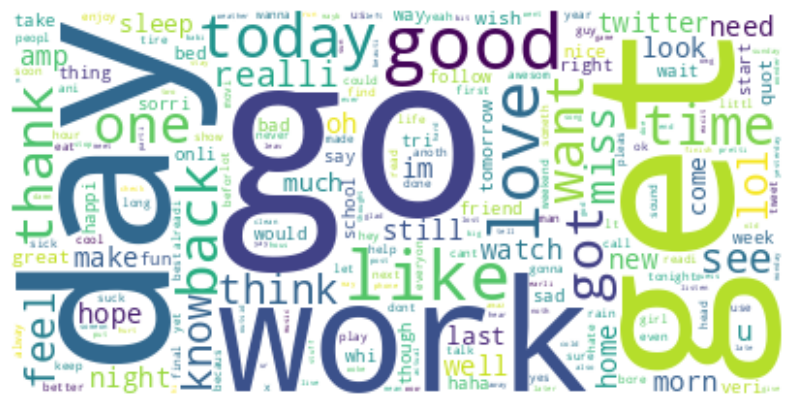

In [ ]:
# get individual words
words = []
for line in data["new_tweet"]:
    words.extend(line)

# create a word frequency dictionary
wordfreq = Counter(words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color="white",
    max_words=500,
    stopwords=stopwords
    ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Visualising most common words that are being labelled as 'Negative'

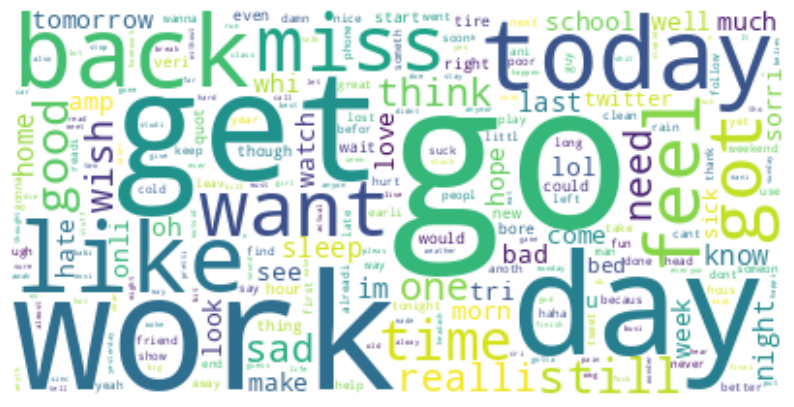

In [ ]:
# get individual words
words = []
for line in data['new_tweet'][data['label']==0]:
    words.extend(line)

# create a word frequency dictionary
wordfreq = Counter(words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color="white",
    max_words=500,
    stopwords=stopwords
    ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Visualising most common words that are being labelled as 'Positive'

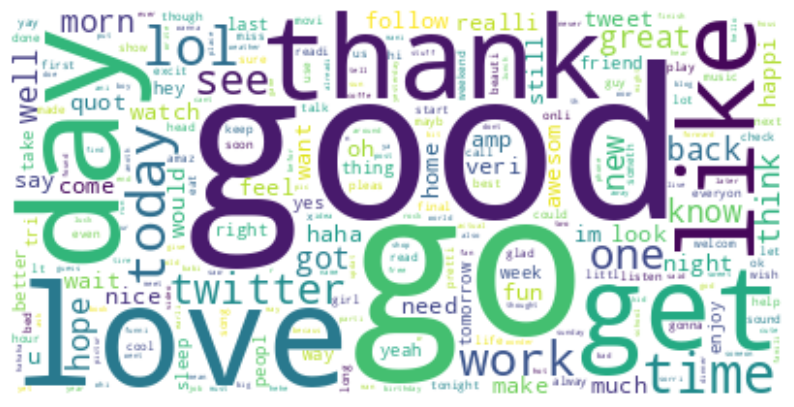

In [ ]:
# get individual words
words = []
for line in data['new_tweet'][data['label']==1]:
    words.extend(line)

# create a word frequency dictionary
wordfreq = Counter(words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color="white",
    max_words=500,
    stopwords=stopwords
    ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#  One hot encoding (Bag of words)

In [ ]:
# joining individual tokens into a string to fit into vectorizer
data['new_tweet'] = data['new_tweet'].apply(lambda x: ' '.join(x))

In [ ]:
# train test split of data where training is 80% and testing is 20% of the dataset
x_train, x_test, y_train, y_test = train_test_split(data["new_tweet"], data["label"], test_size = 0.2, random_state = 101)

In [ ]:
count_vect = CountVectorizer(stop_words='english')
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features = 10000, stop_words='english')

In [ ]:
x_train_tfidf = vectorizer.fit_transform(x_train)
print(x_train_tfidf.shape)

x_test_tfidf = vectorizer.transform(x_test)
print(x_test_tfidf.shape)

(80000, 10000)
(20000, 10000)


# Model Training: Random Forest & Logistic Regression

In [ ]:
# Import the machine learning models you want to test
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Define a dictionary of models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=None,    # Adjust based on data complexity
        min_samples_split=2,  # Adjust for overfitting
        min_samples_leaf=1,   # Adjust for overfitting
        random_state=101
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=101,
        C=1.0,
        solver='lbfgs'    # Often a good choice for large datasets
    )
}

In [ ]:
# Iterate through the models, train, and evaluate them
for model_name, model in models.items():
    model.fit(x_train_tfidf, y_train)
    y_val_pred = model.predict(x_test_tfidf)
    accuracy = accuracy_score(y_test, y_val_pred)
    f1 = f1_score(y_test, y_val_pred)
    print(f"Model: {model_name}")
    print(f"Accuracy on Validation Set: {accuracy:.2f}")

    # Once satisfied, test the model on the test set
    y_test_pred = model.predict(x_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print("\nEvaluation on Test Set:")
    print(f"Accuracy on Test Set: {test_accuracy:.2f}")

    # Add classification report for more details
    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred, target_names=['Negative', 'Positive'])
    print(report)

    print("-" * 50)


Model: Random Forest
Accuracy on Validation Set: 0.74

Evaluation on Test Set:
Accuracy on Test Set: 0.74

Classification Report on Test Set:
              precision    recall  f1-score   support

    Negative       0.75      0.73      0.74     10037
    Positive       0.74      0.75      0.74      9963

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000

--------------------------------------------------
Model: Logistic Regression
Accuracy on Validation Set: 0.75

Evaluation on Test Set:
Accuracy on Test Set: 0.75

Classification Report on Test Set:
              precision    recall  f1-score   support

    Negative       0.77      0.73      0.75     10037
    Positive       0.74      0.78      0.76      9963

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

-----

#### Hyperparameter Tuning for Random Forest & Logistic Regression

In [ ]:
# Define a dictionary of models and hyperparameters to test
models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': list(range(100, 500)),  # Provide a list of choices
            'max_depth': [None, 10, 20, 30, 40, 50],
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Regularization parameter
        }
    }
}

In [ ]:
# Iterate through the models, perform hyperparameter tuning using RandomizedSearchCV, train, and evaluate them
for model_name, config in models.items():
    model = config['model']
    params = config['params']

    # Hyperparameter tuning using RandomizedSearchCV
    random_search = RandomizedSearchCV(model, params, n_iter=10, cv=5, n_jobs=-1, scoring='accuracy', random_state=101)
    random_search.fit(x_train_tfidf, y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Predict on the validation set
    y_val_pred = best_model.predict(x_test_tfidf)

    # Calculate accuracy and F1 score on the validation set
    accuracy = accuracy_score(y_test, y_val_pred)
    f1 = f1_score(y_test, y_val_pred)

    # Print the results
    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {random_search.best_params_}")
    print(f"Accuracy on Validation Set: {accuracy:.2f}")

    # Once satisfied, test the model on the test set
    y_test_pred = best_model.predict(x_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print("\nEvaluation on Test Set:")
    print(f"Accuracy on Test Set: {test_accuracy:.2f}")

    # Add classification report for more details
    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred, target_names=['Negative', 'Positive'])
    print(report)

    print("-" * 50)


Model: Random Forest
Best Hyperparameters: {'n_estimators': 175, 'max_depth': None}
Accuracy on Validation Set: 0.74

Evaluation on Test Set:
Accuracy on Test Set: 0.74

Classification Report on Test Set:
              precision    recall  f1-score   support

    Negative       0.75      0.73      0.74     10037
    Positive       0.74      0.75      0.74      9963

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000

--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Best Hyperparameters: {'C': 1}
Accuracy on Validation Set: 0.75

Evaluation on Test Set:
Accuracy on Test Set: 0.75

Classification Report on Test Set:
              precision    recall  f1-score   support

    Negative       0.77      0.73      0.75     10037
    Positive       0.74      0.78      0.76      9963

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

--------------------------------------------------
Model: K-Nearest Neighbors
Best Hyperparameters: {'n_neighbors': 2}
Accuracy on Validation Set: 0.61

Evaluation on Test Set:
Accuracy on Test Set: 0.61

Classification Report on Test Set:
              precision    recall  f1-score   support

    Negative       0.57      0.85      0.68     10037
    Positive       0.71      0.36      0.48      9963

    accuracy                           0.61     20000
   macro avg       0.64      0.61   

# Model Training: K-Nearest Neighbours (KNN)


In [ ]:
# Create a K-Nearest Neighbors (KNN) classifier
knn = KNeighborsClassifier()

# Train and evaluate the baseline KNN model
knn.fit(x_train_tfidf, y_train)
baseline_predictions = knn.predict(x_test_tfidf)

# Calculate and display the baseline accuracy
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print("Baseline Accuracy:", baseline_accuracy)

# Display classification report for the baseline model
print(classification_report(y_test, baseline_predictions))

KNeighborsClassifier(n_neighbors=10)

#### Hyperparameter Tuning for KNN

In [ ]:
# Define hyperparameter search space
n_neighbors = list(range(1, 50))  # Range of neighbors to consider
p_values = [1, 2]  # Values for the distance metric (1: Manhattan, 2: Euclidean)

# Create a dictionary of hyperparameters for RandomizedSearchCV
hyperparameters = {
    'n_neighbors': n_neighbors,
    'p': p_values
}

# Initialize and configure RandomizedSearchCV
clf = RandomizedSearchCV(
    knn,  # KNN classifier
    hyperparameters,  # Hyperparameter space
    n_iter=10,  # Number of random combinations to try
    scoring='accuracy',  # Scoring metric
    n_jobs=-1,  # Use all available CPU cores
    random_state=1  # Set a random seed for reproducibility
)

# Perform hyperparameter tuning
best_model = clf.fit(x_train_tfidf, y_train)

# Get the best hyperparameters from the search
best_p = best_model.best_params_['p']
best_n_neighbors = best_model.best_params_['n_neighbors']

# Train the best KNN model using the discovered hyperparameters
best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, p=best_p)
best_knn.fit(x_train_tfidf, y_train)

# Make predictions using the best model
best_predictions = best_knn.predict(x_test_tfidf)

# Calculate and display the accuracy of the best model
best_accuracy = accuracy_score(y_test, best_predictions)
print("Best Model Accuracy:", best_accuracy)

# Display classification report for the best model
print(classification_report(y_test, best_predictions))